In [31]:
# pip install yfinance ta keras-tcn


In [32]:
import os 
os.environ["OMP_NUM_THREADS"] = "16"

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(16)
tf.config.threading.set_inter_op_parallelism_threads(16)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import ta  # For technical indicators
from sklearn.preprocessing import MinMaxScaler
import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, SimpleRNN, GRU, Input
from tcn import TCN
import matplotlib.pyplot as plt

In [34]:

def floor_5_or_int(x):
    return int((x // 5) * 5) if x >= 5 else int(x // 1)

# ----------------------------------------------------
#  COMPUTE FRAMA
# ----------------------------------------------------
def compute_frama(series, window=16, fc=1, sc=200):
    """
    Compute FRAMA (Fractal Adaptive Moving Average)
    John Ehlers original algorithm.
    series : pandas Series of prices
    window : lookback length for fractal dimension (default 16)
    fc : fast constant (default 1)
    sc : slow constant (default 200)
    """
    close = series.values
    n = window

    frama = np.zeros(len(close))
    frama[:] = np.nan

    for i in range(n * 2, len(close)):
        # First half
        hl1 = max(close[i-n:i]) - min(close[i-n:i])
        # Second half
        hl2 = max(close[i-2*n:i-n]) - min(close[i-2*n:i-n])
        # Whole window
        hl = max(close[i-2*n:i]) - min(close[i-2*n:i])

        # Avoid division errors
        if hl1 == 0 or hl2 == 0 or hl == 0:
            continue

        # Fractal dimension
        dim = (np.log(hl1 + hl2) - np.log(hl)) / np.log(2)

        # Smoothing factor
        alpha = np.exp(-4.6 * (dim - 1))
        alpha = max(min(alpha, 1), 0.01)  # Bound between 0.01 and 1

        # FRAMA recursive formula
        if np.isnan(frama[i-1]):
            frama[i] = close[i]
        else:
            frama[i] = alpha * close[i] + (1 - alpha) * frama[i-1]

    return pd.Series(frama, index=series.index)


# ---------------------------------------------------------
# 1) TOS RSI With Divergence
# ---------------------------------------------------------
def compute_tos_rsi(df, n=14, over_bought=70, over_sold=30):
    """
    Exact ThinkOrSwim-style RSI:
    NetChgAvg = ExpAverage(c - c[1], n)
    TotChgAvg = ExpAverage(|c - c[1]|, n)
    RSI       = 50 * (NetChgAvg / TotChgAvg + 1)
    """
    c = df["Close"].astype(float)

    # price change
    delta = c.diff()

    # TOS ExpAverage = EMA with alpha = 2/(n+1)
    net_chg_avg = delta.ewm(span=n, adjust=False).mean()
    tot_chg_avg = delta.abs().ewm(span=n, adjust=False).mean()

    chg_ratio = np.where(tot_chg_avg != 0, net_chg_avg / tot_chg_avg, 0.0)
    rsi = 50 * (chg_ratio + 1)

    out = pd.DataFrame(index=df.index)
    out["TOS_RSI"] = rsi
    out["OverBought"] = over_bought
    out["OverSold"] = over_sold

    return out

# ---------------------------------------------------------
# 1) EXACT TOS MODIFIED ATR
# ---------------------------------------------------------
def tos_atr_modified(df, atr_period=10):
    high = df["High"].values.astype(float)
    low  = df["Low"].values.astype(float)
    close = df["Close"].values.astype(float)
    n = len(df)

    # ----- HiLo -----
    hl = high - low
    sma_hl = pd.Series(hl).rolling(atr_period).mean().values

    # TOS behavior: if SMA not ready, just use hl (no NaNs)
    hilo = np.where(np.isnan(sma_hl), hl, np.minimum(hl, 1.5 * sma_hl))

    # ----- HRef / LRef -----
    href = np.zeros(n)
    lref = np.zeros(n)

    for i in range(1, n):
        # HRef
        if low[i] <= high[i-1]:
            href[i] = high[i] - close[i-1]
        else:
            href[i] = (high[i] - close[i-1]) - 0.5 * (low[i] - high[i-1])

        # LRef
        if high[i] >= low[i-1]:
            lref[i] = close[i-1] - low[i]
        else:
            lref[i] = (close[i-1] - low[i]) - 0.5 * (low[i-1] - high[i])

    # ----- True Range -----
    # After the HiLo fix, none of these should be NaN
    tr = np.maximum(hilo, np.maximum(href, lref))

    # ----- Wilder-style ATR, TOS-style init -----
    atr = np.full(n, np.nan)
    if n > 1:
        atr[1] = tr[1]  # seed with first TR

    alpha = 1.0 / atr_period
    for i in range(2, n):
        atr[i] = atr[i-1] + alpha * (tr[i] - atr[i-1])

    return pd.Series(atr, index=df.index, name="TOS_ATR")

# ---------------------------------------------------------
# 2) FULL TOS TRAILING STOP (STATE MACHINE)
# ---------------------------------------------------------
def tos_trailing_stop(df, atr_period=10, atr_factor=1.5, first_trade="long"):
    atr = tos_atr_modified(df, atr_period).values
    close = df["Close"].values.astype(float)
    n = len(df)

    loss  = atr_factor * atr
    state = np.full(n, "init", dtype=object)
    trail = np.full(n, np.nan)

    for i in range(1, n):
        # INIT: first bar with non-NaN loss starts the system
        if state[i-1] == "init":
            if not np.isnan(loss[i]):
                if first_trade == "long":
                    state[i] = "long"
                    trail[i] = close[i] - loss[i]
                else:
                    state[i] = "short"
                    trail[i] = close[i] + loss[i]
            else:
                state[i] = "init"
                trail[i] = np.nan
            continue

        prev_state = state[i-1]
        prev_trail = trail[i-1]

        if prev_state == "long":
            if close[i] > prev_trail:
                state[i] = "long"
                trail[i] = max(prev_trail, close[i] - loss[i])
            else:
                state[i] = "short"
                trail[i] = close[i] + loss[i]
        else:  # prev_state == "short"
            if close[i] < prev_trail:
                state[i] = "short"
                trail[i] = min(prev_trail, close[i] + loss[i])
            else:
                state[i] = "long"
                trail[i] = close[i] - loss[i]

    # ---- Buy / Sell when state flips ----
    buy  = np.zeros(n, dtype=bool)
    sell = np.zeros(n, dtype=bool)

    for i in range(1, n):
        buy[i]  = (state[i] == "long"  and state[i-1] != "long")
        sell[i] = (state[i] == "short" and state[i-1] != "short")

    return pd.DataFrame(
        {
            "TOS_ATR": atr,
            "TOS_Trail": trail,
            "TOS_State": state,
            "TOS_Buy": buy,
            "TOS_Sell": sell,
        },
        index=df.index,
    )


def compute_vwap_with_bands(df, num_dev_up=2.0, num_dev_dn=-2.0, anchor="DAY"):
    tp = (df["High"] + df["Low"] + df["Close"]) / 3

    # --- FIX ZERO VOLUME ---
    vol = df["Volume"].replace(0, 1)   # essential for indices like SPX

    # --- anchor periods ---
    if anchor == "DAY":
        period = df.index.date
    elif anchor == "WEEK":
        period = df.index.to_period("W").astype(str)
    elif anchor == "MONTH":
        period = df.index.to_period("M").astype(str)

    # --- cumulative values ---
    vol_sum = vol.groupby(period).cumsum()
    vol_tp_sum = (vol * tp).groupby(period).cumsum()
    vol_tp2_sum = (vol * (tp ** 2)).groupby(period).cumsum()

    # --- VWAP ---
    vwap = vol_tp_sum / vol_sum

    # --- STD DEV ---
    variance = (vol_tp2_sum / vol_sum) - (vwap ** 2)
    variance = variance.clip(lower=0)
    deviation = np.sqrt(variance)

    upper = vwap + num_dev_up * deviation
    lower = vwap + num_dev_dn * deviation

    # --- Remove first bar of each day/month/week ---
    first_idx = df.index.to_series().groupby(period).head(1).index
    vwap.loc[first_idx] = np.nan
    upper.loc[first_idx] = np.nan
    lower.loc[first_idx] = np.nan

    return upper, vwap, lower


# ----------------------------------------------------
#  SAFE PRICE DOWNLOADER (YFINANCE WITHOUT MULTIINDEX)
# ----------------------------------------------------
def download_price(ticker, start, end, timeframe=None):
    """
    ALWAYS returns a clean DataFrame:
    Date | Open | High | Low | Close | Volume | Adj_Close
    """
    if timeframe == '1d' or timeframe is None:
        df = yf.download(ticker, start=start, end=end, auto_adjust=False)
    else:
        df = yf.download(ticker, start=start, end=end, interval=timeframe,  prepost=True, auto_adjust=False)
        df = df.tz_convert("America/Chicago")
    # --------------- FIX MULTIINDEX ---------------
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # --------------- STANDARDIZE NAMES ---------------
    df = df.rename(columns={
        "Adj Close": "Adj_Close",
        "Close": "Close",
        "Open": "Open",
        "High": "High",
        "Low": "Low",
        "Volume": "Volume"
    })

    # Ensure correct dtype
    df = df[["Open","High","Low","Close","Volume","Adj_Close"]]
    # print(df.tail(5))
    return df


# ----------------------------------------------------
#  Feature Configuration
# ----------------------------------------------------
feature_params = {
    "sma_short": 9,
    "sma_mid": 50,
    "sma_long": 200,
    "trend_slope_short": 5,
    "trend_slope_long": 20,
    "rsi_length": 14,
    "stoch_length": 14,
    "stoch_signal": 3,
    "macd_fast": 12,
    "macd_slow": 26,
    "macd_signal": 9,
    "adx_length": 14,
    "atr_length": 5,
    "bollinger_length": 20,
    "volatility_length": 20,
    "volume_zscore_length": 20,
    "volume_change_length": 1,
}


# ----------------------------------------------------
#  Helper: Linear Regression Slope
# ----------------------------------------------------
def trend_slope(series):
    y = np.asarray(series).astype(float)
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0]


# ----------------------------------------------------
#  Market Context (VIX + SPY)
# ----------------------------------------------------
def get_market_context(start, end, timeframe):

    vix = download_price("^VIX", start, end, timeframe)
    vix = vix.rename(columns={"Close": "VIX_Close"})[["VIX_Close"]]

    spy = download_price("SPY", start, end, timeframe)
    spy["SPY_Return"] = spy["Close"].pct_change()
    spy["SPY_Volatility_20"] = spy["Close"].pct_change().rolling(20).std()

    return pd.concat([vix, spy[["SPY_Return","SPY_Volatility_20"]]], axis=1)


# ----------------------------------------------------
#  Core Feature Engineering
# ----------------------------------------------------
def add_features(df, p, timeframe=None):

    # -------- Trend --------
    df["SMA_Short"] = df["Close"].rolling(p["sma_short"]).mean()
    df["SMA_Mid"]   = df["Close"].rolling(p["sma_mid"]).mean()
    df["SMA_Long"]  = df["Close"].rolling(p["sma_long"]).mean()

    df["Slope_Short"] = df["Close"].rolling(p["trend_slope_short"]) \
        .apply(trend_slope, raw=False)
    df["Slope_Long"]  = df["Close"].rolling(p["trend_slope_long"]) \
        .apply(trend_slope, raw=False)

    # -------- FRAMA --------
    df["FRAMA"] = compute_frama(df["Close"], window=16)
    
    # -------- Momentum --------
    df["RSI"] = ta.momentum.rsi(df["Close"], window=p["rsi_length"])

    st = ta.momentum.StochasticOscillator(
        df["High"], df["Low"], df["Close"],
        window=p["stoch_length"],
        smooth_window=p["stoch_signal"]
    )
    df["Stoch_K"] = st.stoch()
    df["Stoch_D"] = st.stoch_signal()

    macd = ta.trend.MACD(
        close=df["Close"],
        window_slow=p["macd_slow"],
        window_fast=p["macd_fast"],
        window_sign=p["macd_signal"]
    )
    df["MACD"]        = macd.macd()
    df["MACD_Signal"] = macd.macd_signal()
    df["MACD_Hist"]   = macd.macd_diff()

    df["ADX"] = ta.trend.adx(df["High"], df["Low"], df["Close"], window=p["adx_length"])

    # -------- Volatility --------
    df["ATR"] = ta.volatility.average_true_range(
        df["High"], df["Low"], df["Close"], window=p["atr_length"]
    )
    df["ATR_pct"] = df["ATR"] / df["Close"]
    df["Daily_Return"] = df["Close"].pct_change()
    df["Daily_Delta"] = df["Close"] - df["Close"].shift(1)
    df["Daily_Delta"] = df["Daily_Delta"].fillna(0)
    df["Volatility_20"] = df["Daily_Return"].rolling(
        p["volatility_length"]
    ).std()

    bb = ta.volatility.BollingerBands(df["Close"], window=p["bollinger_length"], window_dev=2)
    df["BB_Upper"] = bb.bollinger_hband()
    df["BB_Mid"]   = bb.bollinger_mavg()
    df["BB_Lower"] = bb.bollinger_lband()
    df["BB_Width"] = bb.bollinger_wband()

    # -------- Volume --------
    df["Volume_Zscore"] = (
        df["Volume"] - df["Volume"].rolling(p["volume_zscore_length"]).mean()
    ) / df["Volume"].rolling(p["volume_zscore_length"]).std()

    df["Volume_Change"] = df["Volume"].pct_change()
    df["OBV"] = ta.volume.on_balance_volume(df["Close"], df["Volume"])

    df["CMF"] = ta.volume.chaikin_money_flow(
        df["High"], df["Low"], df["Close"], df["Volume"], window=20
    )

    # -------- Candle Structure --------
    df["Gap"] = (df["Open"] - df["Close"].shift(1)) / df["Close"].shift(1)
    df["Candle_Body"] = (df["Close"] - df["Open"]) / (df["High"] - df["Low"] + 1e-9)
    
    # -------- VWAP --------
    if timeframe in ["5m", "15m", "30m", "1h", "4h"]:
        df["VWAP_Upper"], df["VWAP"], df["VWAP_Lower"] = compute_vwap_with_bands(df)

    # -------- TOS ATR --------
    tos = tos_trailing_stop(df, atr_period=5, atr_factor=1.5)
    df["TOS_Trail"] = tos["TOS_Trail"]


    # # -------- TOS RSI With Divergence  --------
    tos_rsi = compute_tos_rsi(df, 9, 70, 30)
    df["TOS_RSI"]      = tos_rsi["TOS_RSI"]


    return df


# ----------------------------------------------------
#  FINAL DATASET BUILDER
# ----------------------------------------------------
def build_feature_dataset(ticker, start_date="2010-01-01", end_date=None, timeframe=None):

    ohlcv = download_price(ticker, start_date, end_date, timeframe=timeframe)

    feat  = add_features(ohlcv.copy(), feature_params, timeframe=timeframe)

    market = get_market_context(start_date, end_date, timeframe=timeframe)
    market = market.reindex(feat.index)

    out = feat.join(market)

    # DO NOT DROPNA HERE — we drop AFTER labeling
    return out


In [35]:
print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

# Set TF_GPU_ALLOCATOR environment variable
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Available GPUs: 
[]



In [36]:
def preprocess_data(df, features, target, n_timesteps, test_start='2025-01-01'):
    # 1) Select cols
    cols = list(features)
    if target not in cols:
        cols.append(target)

    data = df[cols]

    # 2) Date split into train/test (NO ratios)
    train_data = data.loc[:test_start]
    test_data  = data.loc[test_start:]

    # 3) Fit scaler ONLY on training
    scaler = MinMaxScaler()
    scaler.fit(train_data.values)

    scaled_train = scaler.transform(train_data.values)
    scaled_test  = scaler.transform(test_data.values)

    # 4) Target index
    target_idx = cols.index(target)

    # 5) Build train sequences
    X_train, y_train = [], []
    for i in range(n_timesteps, len(scaled_train)-1):
        X_train.append(scaled_train[i-n_timesteps:i])
        y_train.append(scaled_train[i, target_idx])

    # 6) Build test sequences
    X_test, y_test = [], []
    for i in range(n_timesteps, len(scaled_test)-1):
        X_test.append(scaled_test[i-n_timesteps:i])
        y_test.append(scaled_test[i, target_idx])

    return (np.array(X_train), np.array(y_train),
            np.array(X_test), np.array(y_test), scaled_test,
            scaler, cols)



# Build the hybrid TCN + LSTM model
def build_hybrid_model(n_timesteps, n_features):
    model = Sequential()
    model.add(Input(shape=(n_timesteps, n_features)))

    model.add(Bidirectional(LSTM(512, activation='tanh',
                            return_sequences=True, 
                            recurrent_dropout=0.2
                            )))

    model.add(Bidirectional(LSTM(256, activation='tanh' #, 
                            # recurrent_dropout=0.2
                            )))
    
    # # Dense output layer
    model.add(Dense(64))
    model.add(keras.layers.Dropout(0.2))
    model.add(Dense(1))  # Predicting a single value (next stock price)

    model.compile(optimizer='adam', loss='mae') # 'mae' tf.keras.losses.Huber()
    model.summary()
    return model

In [37]:
# Get stock data (AAPL from 2020-01-01 to 2023-01-01)
ticker = 'TSLA'

stock_data = build_feature_dataset(ticker, start_date="2021-01-01", end_date="2026-01-21", timeframe="1d")
stock_data = stock_data.dropna()
stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_Short', 
            'SMA_Mid', 'SMA_Long', 'Slope_Long', 'Slope_Short',
            'MACD', 'ADX', 'BB_Upper', 'BB_Mid', 'BB_Lower', 
            'TOS_Trail', 'TOS_RSI', 'Daily_Delta']].tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume,SMA_Short,SMA_Mid,SMA_Long,Slope_Long,Slope_Short,MACD,ADX,BB_Upper,BB_Mid,BB_Lower,TOS_Trail,TOS_RSI,Daily_Delta
Date,,,,,,,,,,,,,,,,,,
2026-01-13,450.200012,451.809998,443.950012,447.200012,53719200,442.311113,444.147202,366.50340,-2.847376,4.474002,-1.964846,19.866842,500.901275,461.338503,421.775730,453.848205,50.868288,-1.759979
2026-01-14,442.809998,443.910004,434.220001,439.200012,57259500,441.142225,443.800002,367.38165,-2.943038,0.899005,-2.566397,19.876625,499.672207,459.533003,419.393800,453.848205,38.865116,-8.000000
2026-01-15,441.130005,445.359985,437.649994,438.570007,49465800,441.197781,443.204002,368.27870,-2.763346,-2.263998,-3.058707,19.749274,495.548973,456.967503,418.386033,453.848205,37.982849,-0.630005
2026-01-16,439.500000,447.250000,435.260010,437.500000,60047300,439.623335,443.068802,369.12390,-2.878940,-3.154999,-3.494920,19.791776,494.649426,455.479503,416.309580,453.848205,36.236467,-1.070007
2026-01-20,429.345001,430.725006,417.440002,419.250000,62351009,438.100003,442.212402,369.80635,-2.956128,-5.760004,-5.252695,20.859683,492.274860,452.273503,412.272146,439.524188,18.298918,-18.250000


In [38]:
# Number of timesteps to look back (e.g., 60 days)
n_timesteps = 60

TARGET = 'Slope_Short'
FEATURES = ['Open', 'High', 'Close', 'Low', 'Volume', 'SMA_Short', 'Daily_Delta',
            'SMA_Mid', 'SMA_Long', 'Slope_Long', 
            'MACD', 'ADX', 'BB_Upper', 'BB_Mid', 'BB_Lower',  
            'TOS_Trail', 'TOS_RSI']


# Preprocess data to create sequences
X_train, y_train, X_test, y_test, scaled_test,scaler, cols = preprocess_data(
    stock_data,
    FEATURES,
    TARGET,
    n_timesteps=n_timesteps
)

split_valid = int(0.9*len(X_train))
X_train90, X_valid10 = X_train[:split_valid], X_train[split_valid:]
y_train90, y_valid10 = y_train[:split_valid], y_train[split_valid:]


In [39]:
# # Build the hybrid model (LSTM)
# model = build_hybrid_model(n_timesteps, X_train90.shape[2])

# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# # Train the model
# model.fit(X_train90, y_train90, epochs=200, batch_size=128, callbacks=[es], shuffle=False, validation_data=(X_valid10, y_valid10))

model = load_model(f"./{ticker}_daily_delta_lstm.h5")


In [40]:
# Predict scaled target
y_pred = model.predict(X_test)

# Find target index in scaler space
target_idx = cols.index(TARGET)

# Build dummy full vectors for inverse scaling
fake_pred = np.zeros((len(y_pred), len(cols)))
fake_test = np.zeros((len(y_test), len(cols)))

# Fill fake vectors using last timestep of X_test (scaled)
fake_pred[:] = X_test[:, -1, :]
fake_test[:] = X_test[:, -1, :]

# Replace only target dimension
fake_pred[:, target_idx] = y_pred[:, 0]
fake_test[:, target_idx] = y_test

# Inverse transform
inv_pred = scaler.inverse_transform(fake_pred)
inv_test = scaler.inverse_transform(fake_test)

# Extract rescaled slope target
y_pred_rescaled = inv_pred[:, target_idx]
y_test_rescaled = inv_test[:, target_idx]


7/7 [==============================] - 1s 39ms/step


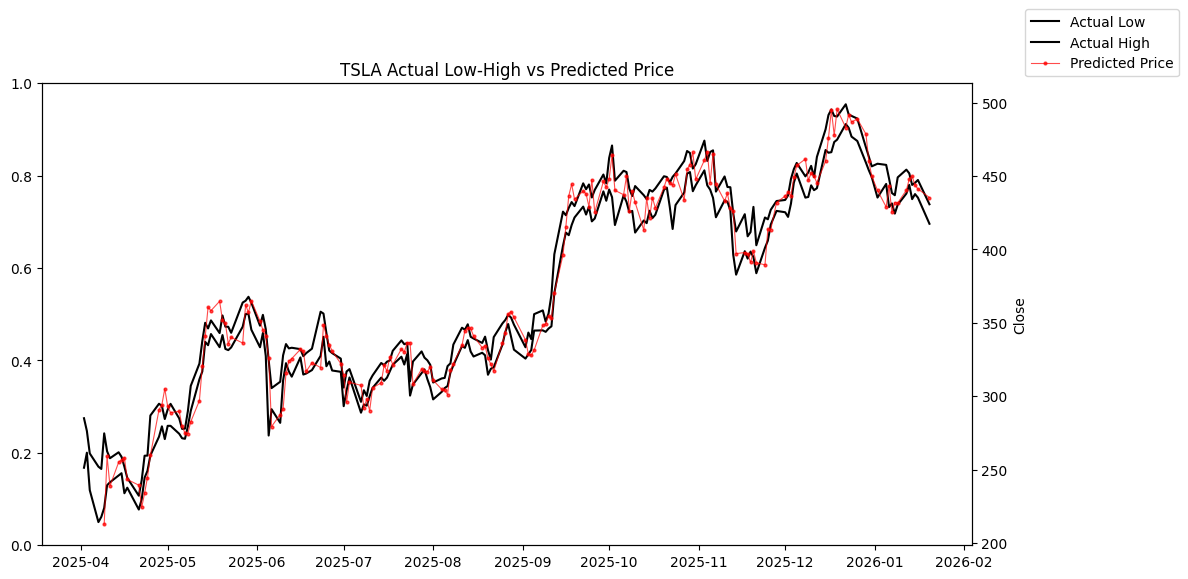

,Date,Low,High,Open,Close,Predicted Price,Prediction Lower Band,Prediction Upper Band,Close within Predicted Buffer,Prediction within OHLC,Directional Accuracy,Directional Buffer Accuracy
190,2026-01-06,428.779999,448.250000,446.380005,432.959991,443.254013,416.657741,469.850285,True,True,True,True
191,2026-01-07,431.290009,438.369995,435.899994,431.410004,425.235895,398.734837,451.736954,True,False,True,True
192,2026-01-08,424.369995,436.890015,427.890015,435.799988,431.849636,405.078905,458.620366,True,True,True,True
193,2026-01-09,430.390015,449.049988,435.950012,445.010010,431.626987,404.290494,458.963479,True,True,True,True
194,2026-01-12,438.000000,454.299988,441.230011,448.959991,440.247248,412.668113,467.826383,True,True,True,True
195,2026-01-13,443.950012,451.809998,450.200012,447.200012,447.911990,420.440969,475.383012,True,True,True,True
196,2026-01-14,434.220001,443.910004,442.809998,439.200012,449.755000,422.775409,476.734590,True,False,False,True
197,2026-01-15,437.649994,445.359985,441.130005,438.570007,443.705735,416.764846,470.646625,True,True,True,True
198,2026-01-16,435.260010,447.250000,439.500000,437.500000,441.212195,414.337034,468.087355,True,True,True,True
199,2026-01-20,417.440002,430.725006,429.345001,419.250000,435.306836,409.552754,461.060918,True,False,True,True


In [41]:
fig, ax1 = plt.subplots(figsize=(12,6))

time_index = stock_data.index[-len(y_test_rescaled):]

# slope
# ax1.plot(time_index, y_test_rescaled, label=f'Actual {TARGET}', color='orange')
# ax1.plot(time_index, y_pred_rescaled, label=f'Predicted {TARGET}', color='green')
# ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)
y_diff = (y_test_rescaled - y_pred_rescaled)
# ax1.plot(time_index, y_diff, color='black')
# q25 = pd.Series(y_diff).rolling(3).quantile(0.25)
q50 = pd.Series(y_diff).rolling(5).quantile(0.50)
# q75 = pd.Series(y_diff).rolling(3).quantile(0.75)
# bias = ((q25 + q75)/2).to_numpy()

bias = (q50).to_numpy()

# ax1.plot(time_index, y_diff, color='green', linestyle='--', linewidth=1.3)

# ax1.set_ylabel(TARGET)
# ax1.set_ylim(-15, 15)

# close on secondary axis
ax2 = ax1.twinx()
# ax2.plot(time_index, stock_data['Close'].iloc[-len(y_test_rescaled):], color='blue', linestyle='--',  alpha = 0.6, marker='o', markersize=2, label=f'Actual Close')
ax2.plot(time_index, stock_data['Low'].iloc[-len(y_test_rescaled):], color='black', label=f'Actual Low')
ax2.plot(time_index, stock_data['High'].iloc[-len(y_test_rescaled):], color='black', label=f'Actual High')
ax2.plot(time_index, ((stock_data['Close'].iloc[-len(y_test_rescaled):] + y_pred_rescaled + bias).shift(1)), color='red', 
                        linewidth=0.8, markersize = 2, marker = 'o', label=f'Predicted Price', alpha = 0.7)

ax2.set_ylabel('Close')

# combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', bbox_to_anchor=(1.05, 1))

plt.title(f'{ticker} Actual Low-High vs Predicted Price')
plt.show()


predicted_close = (stock_data['Close'].iloc[-len(y_test_rescaled):] + y_pred_rescaled + bias)

df_seq = -200
temp_df = pd.DataFrame({
    'Date': stock_data.index[df_seq:],
    'Low': stock_data['Low'].iloc[df_seq:].values,
    'High': stock_data['High'].iloc[df_seq:].values,
    'Open': stock_data['Open'].iloc[df_seq:].values,
    'Close': stock_data['Close'].iloc[df_seq:].values,
    'Predicted Price': predicted_close[df_seq:].shift(1).values,
    # 'Bias': bias[df_seq:],
    # 'Actual Delta': y_test_rescaled[df_seq:],
    # 'Predicted Delta': y_pred_rescaled[df_seq:]
    })

pred_delta_pct = (temp_df['Predicted Price'] - temp_df['Close']) / temp_df['Close']*100
# safe = (pred_delta_pct.abs().median() + pred_delta_pct.abs().std())
safe = (pred_delta_pct.abs().quantile(0.9))
# print(safe)
buffer = temp_df['Close'] * safe/100

temp_df['Prediction Lower Band'] = temp_df['Predicted Price'] - buffer
temp_df['Prediction Upper Band'] = temp_df['Predicted Price'] + buffer
temp_df['Close within Predicted Buffer'] = (
    (temp_df['Close'] >= temp_df['Prediction Lower Band']) &
    (temp_df['Close'] <= temp_df['Prediction Upper Band'])
)
    
temp_df['Prediction within OHLC'] = (
    (temp_df['Predicted Price'] >= temp_df['Low']) &
    (temp_df['Predicted Price'] <= temp_df['High'])
)


temp_df['ActualDir'] = np.sign(temp_df['Close'] - temp_df['Close'].shift(1))
temp_df['PredDir'] = np.sign(temp_df['Predicted Price'] - temp_df['Predicted Price'].shift(1))
temp_df['CorrectDir'] = (temp_df['ActualDir'] * temp_df['PredDir']) > 0
temp_df["Directional Accuracy"] = temp_df['Prediction within OHLC'] | temp_df['CorrectDir']
temp_df["Directional Buffer Accuracy"] = temp_df['Close within Predicted Buffer'] | temp_df['CorrectDir']


temp_df = temp_df.drop(columns=['ActualDir', 'PredDir', 'CorrectDir'])
temp_df = temp_df.dropna()
temp_df.tail(10)


In [42]:
# pred_delta = (temp_df['Predicted Price'] - temp_df['Close'])/temp_df['Close']*100
# pred_delta.plot(kind='hist', bins=30, title='Predicted Price % Change Distribution')
# plt.show()
# safe = pred_delta.abs().quantile(0.9)
# print(safe)


In [43]:
print('Ticker:', ticker, "- Next Predicted Direction:", 'Down' if predicted_close.iloc[-1] < predicted_close.iloc[-2] else 'Up')
# print("Next Predicted Direction:", 'Down' if predicted_close.iloc[-1] < predicted_close.iloc[-2] else 'Up')
print("Next Predicted Price:", round(predicted_close.iloc[-1],2))
print("Predicted Price Buffer %:", round(safe, 3))
print("Next Prediction Lower Band:", round(temp_df['Prediction Lower Band'].iloc[-1],2))
print("Next Prediction Upper Band:", round(temp_df['Prediction Upper Band'].iloc[-1],2))

price_accuracy = temp_df['Prediction within OHLC'].mean()*100
print("Predicted Price within OHLC %:", round(price_accuracy, 3))

buffer_accuracy = temp_df['Close within Predicted Buffer'].mean()*100
print("Close within Predicted Buffer %:", round(buffer_accuracy, 3))

directional_accuracy = temp_df['Directional Accuracy'].mean()*100
print("Directional Accuracy %:", round(directional_accuracy, 3))

directional_buffer_accuracy = temp_df['Directional Buffer Accuracy'].mean()*100
print("Directional Buffer Accuracy %:", round(directional_buffer_accuracy, 3))

Ticker: TSLA - Next Predicted Direction: Down
Next Predicted Price: 415.85
Predicted Price Buffer %: 6.143
Next Prediction Lower Band: 409.55
Next Prediction Upper Band: 461.06
Predicted Price within OHLC %: 55.612
Close within Predicted Buffer %: 89.796
Directional Accuracy %: 77.041
Directional Buffer Accuracy %: 93.367


In [44]:
# Take the last n_timesteps rows from the *test* (or full) scaled data
# last_block = scaler.transform(stock_data[cols].values)[-n_timesteps:]
seq = -1
last_block = X_test[seq] # scaled_test[-n_timesteps:]
X_next = last_block.reshape(1, n_timesteps, len(cols))
y_next_scaled = model.predict(X_next)
target_idx = cols.index(TARGET)

# Build fake vector for inverse scaling
fake_next = np.zeros((1, len(cols)))
fake_next[:] = last_block[-1, :]
fake_next[:, target_idx] = y_next_scaled[0, 0]

inv_next = scaler.inverse_transform(fake_next)
y_next_rescaled = inv_next[0, target_idx]   # this is your "extra" prediction
# print(f"Extra Horizon Predicted {TARGET} (rescaled): {y_next_rescaled:.2f}")


# pred_delta_yday   = y_pred_rescaled[-2]
# actual_delta_today = y_test_rescaled[-1]

actual_close_yday  = stock_data['Close'].iloc[seq-1]
actual_close_today = stock_data['Close'].iloc[seq]

# print(f"{ticker} Actual Delta today: {round(actual_delta_today, 2)}")
print(f"{ticker} Actual Close today: {round(actual_close_today, 2)}")
# print(f"{ticker} Predicted Delta today: {round(y_next_rescaled, 2)}")
# print(f"{ticker} Bias Correction: {bias[seq]:.2f}")
print(f"{ticker} Predicted Close Tomorrow: {actual_close_today + y_next_rescaled + bias[seq]:.2f}")



1/1 [==============================] - 0s 27ms/step
TSLA Actual Close today: 419.25
TSLA Predicted Close Tomorrow: 415.85


In [45]:
# model.save(f"./{ticker}_daily_delta_lstm.h5")
